# Exploratory Data Analysis
From this point all data is taken from already pre-processed, cleaned datasets.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
df_art = pd.read_csv('data/cleaned_articles.csv')
df_rep = pd.read_csv('data/cleaned_chosen_representatives.csv')

df_art["title"].value_counts().head(10)

title
Rep. Boebert Leads Congress in Number of Amendments Filed to Spending Bills                                                 12
Rep. Soto Calls for Senate Action on Key House-Passed Bills and Highlights Some Key Bipartisan Achievements for the Year    11
CONGRESSMAN BISHOP STATEMENT ON 9/11 ANNIVERSARY                                                                            10
CONGRESSMAN BISHOP SECURES HISTORIC INVESTMENT IN AMERICAN FAMILIES AND COMMUNITIES                                          9
THE TRUMP BUDGET: A BAD DEAL FOR GEORGIA’S SECOND CONGRESSIONAL DISTRICT                                                     9
CHAIRMAN BISHOP CONDEMNS CONTINUED HOUSE GOP DELAY OF EXPANDED DISASTER APPROPRIATIONS BILL                                  9
CONGRESSMAN BISHOP STATEMENT REGARDING THE STATE OF THE UNION ADDRESS                                                        8
Pocan Votes to Fund Government for Remainder of FY24                                                     

In [60]:
rep_to_party = dict(zip(df_rep["name"], df_rep["party"]))

title_counts = df_art["title"].value_counts()
representative_counts = df_art["representative_name"].value_counts()

topics_per_article_counts = pd.DataFrame({
    "title": title_counts.index,
    "count": title_counts.values
}).merge(df_art[['title', 'representative_name']].drop_duplicates(), on='title', how='left')

topics_per_article_counts.rename(columns={"representative_name": "representative"}, inplace=True)

topics_per_article_counts["party"] = [rep_to_party[rep] for rep in topics_per_article_counts["representative"]]
topics_per_article_counts.sort_values(by="representative", key=lambda col: representative_counts[col], inplace=True, ascending=False)
topics_per_article_counts["representative"] = topics_per_article_counts["representative"].apply(lambda x: x + f'({representative_counts[x]})')

In [61]:
def describe_axis(ax, title, xlabel, ylabel):
    ax.set_title(title, size=18)
    ax.set_xlabel(xlabel, size=14)
    ax.set_ylabel(ylabel, size=14)

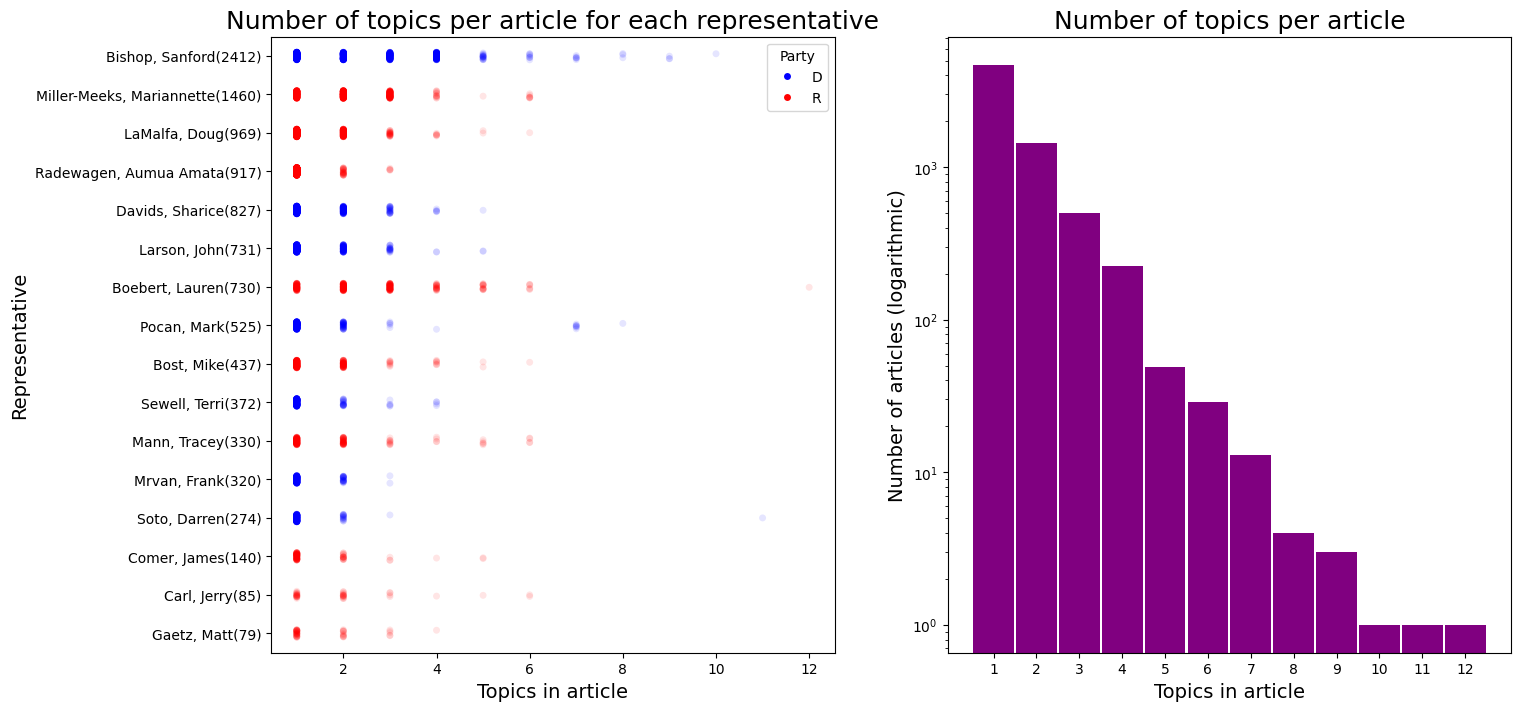

In [62]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(16,8), facecolor="white")

palette = {"D": "blue", "R": "red"}
sns.stripplot(x="count", y="representative", data=topics_per_article_counts, ax=ax[0], jitter=True, alpha=0.1, hue="party", palette=palette)
describe_axis(ax[0], "Number of topics per article for each representative", "Topics in article", "Representative")

# Override alpha for legend
handles, labels = ax[0].get_legend_handles_labels()
for handle in handles:
    handle.set_alpha(1)
ax[0].legend(handles=handles, labels=labels, title="Party")



ax[1].hist(title_counts.values, color="purple", bins = 12, log=True, rwidth=0.95)
describe_axis(ax[1], "Number of topics per article", "Topics in article", "Number of articles (logarithmic)")

#Override x-axis ticks behaviour
bin_edges = ax[1].patches
bin_centers = [patch.get_x() + patch.get_width() / 2 for patch in bin_edges]
ax[1].set_xticks(bin_centers)
ax[1].set_xticklabels(list(range(1, title_counts.max() + 1)));
